In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import resources, report 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import HTML
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import IsolationForest

<div style="text-align:center;font-size:30px; ont-weight:bold;">Loading and exploring the dataset</div>

In [2]:
df  = pd.read_csv('dataset_regression/parkinsons_updrs.data')
df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

In [4]:
# let's remove signs from the columns's names
df = df.rename(columns={
    'subject#': 'subject',
    'Jitter(Abs)': 'Jitter_Abs',
    'Jitter:%': 'Jitter_pct',
    'Shimmer(dB)': 'Shimmer_dB',
    'Jitter(%)': 'Jitter_pct',
    'Shimmer:APQ3': 'Shimmer_APQ3',
    'Shimmer:APQ5': 'Shimmer_APQ5',
    'Shimmer:APQ11': 'Shimmer_APQ11',
    'Shimmer:DDA': 'Shimmer_DDA',
    'Jitter:RAP': 'Jitter_RAP',
    'Jitter:PPQ5': 'Jitter_PPQ5',
    'Jitter:DDP': 'Jitter_DDP'
})

In [5]:
df.describe()

,subject,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter_pct,Jitter_Abs,Jitter_RAP,Jitter_PPQ5,...,Shimmer_dB,Shimmer_APQ3,Shimmer_APQ5,Shimmer_APQ11,Shimmer_DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,...,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,21.494128,64.804936,0.317787,92.863722,21.296229,29.018942,0.006154,0.000044,0.002987,0.003277,...,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,12.372279,8.821524,0.465656,53.445602,8.129282,10.700283,0.005624,0.000036,0.003124,0.003732,...,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,1.000000,36.000000,0.000000,-4.262500,5.037700,7.000000,0.000830,0.000002,0.000330,0.000430,...,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,10.000000,58.000000,0.000000,46.847500,15.000000,21.371000,0.003580,0.000022,0.001580,0.001820,...,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,22.000000,65.000000,0.000000,91.523000,20.871000,27.576000,0.004900,0.000035,0.002250,0.002490,...,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,33.000000,72.000000,1.000000,138.445000,27.596500,36.399000,0.006800,0.000053,0.003290,0.003460,...,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,42.000000,85.000000,1.000000,215.490000,39.511000,54.992000,0.099990,0.000446,0.057540,0.069560,...,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


In [6]:
# mmm test_time column which represents number of days since recruitment. It has decimal and negative values.
# decimal values make sense but negative values do not. I dk what does it mean. 
# let's check how many negative values are there in the column
df[df['test_time'] < 0].value_counts().sum()

12

**Negative values are recorded wrongly so I am going to remove them.**

In [7]:
# Removing the negative values from the test_time column
df = df[df['test_time'] > 0]

**Test_time column has multiple decimals, it makes sense for example 10.5, means 10 days and half days or 12 hours, but having multiple values are useless, so I am gonna keep only one decimal.**

In [8]:
df["test_time"] = df["test_time"].round(1)

<!-- This is a comment in a Markdown cell -->


<Axes: >

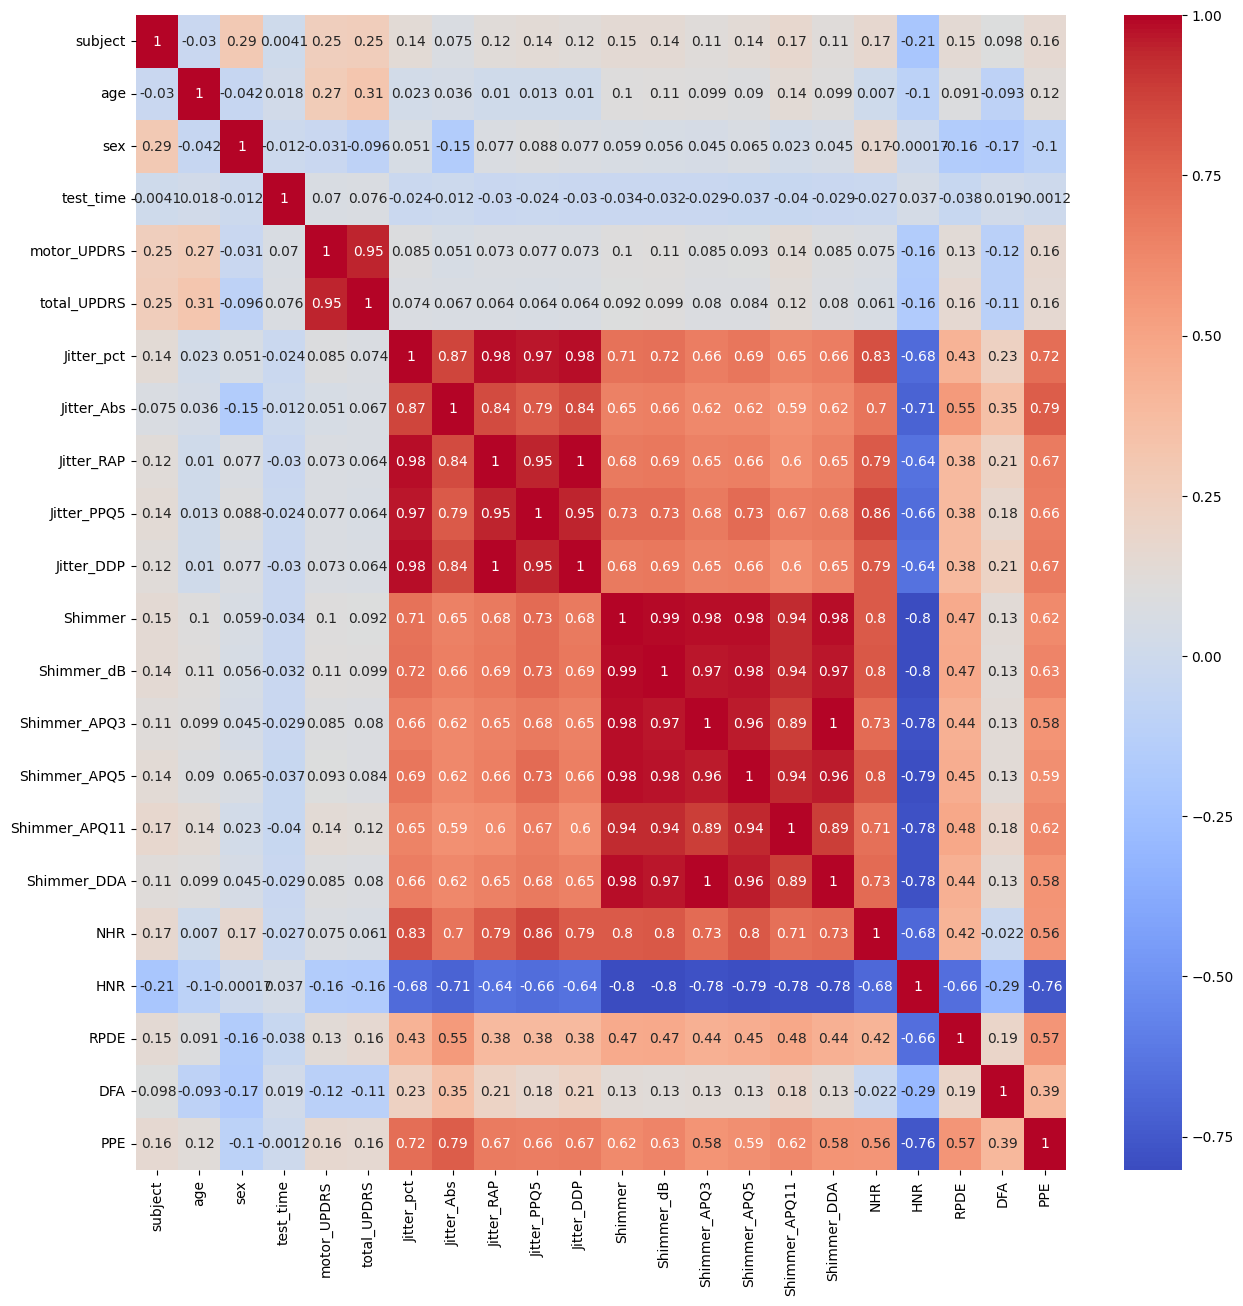

In [9]:
# let's check the correlation
correlation = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

<p> All Jitters values and Shimmers values rise and fall together. Motor and total UPDRS  have strongly correlated.<br>
HNR is strongly negatively correlated with Jitters and Shimmers features which means as voice shakiness or noise goes up (higher Jitter and Shimmer), the harmonic quality of the voice (HNR) goes down.<br>
UPDRS has moderate connection with Jitter values and Shimmers values, which means more unstable or shaky voices come with higher Parkinson's scores.<br>
Age has moderate connection with UPDRS, it makes sense by searching on the internet, older patients show higher Parkinson's scores.</p>

interval columns not set, guessing: ['subject', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter_pct', 'Jitter_Abs', 'Jitter_RAP', 'Jitter_PPQ5', 'Jitter_DDP', 'Shimmer', 'Shimmer_dB', 'Shimmer_APQ3', 'Shimmer_APQ5', 'Shimmer_APQ11', 'Shimmer_DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']


<Axes: title={'center': 'Phik correlation matrix'}>

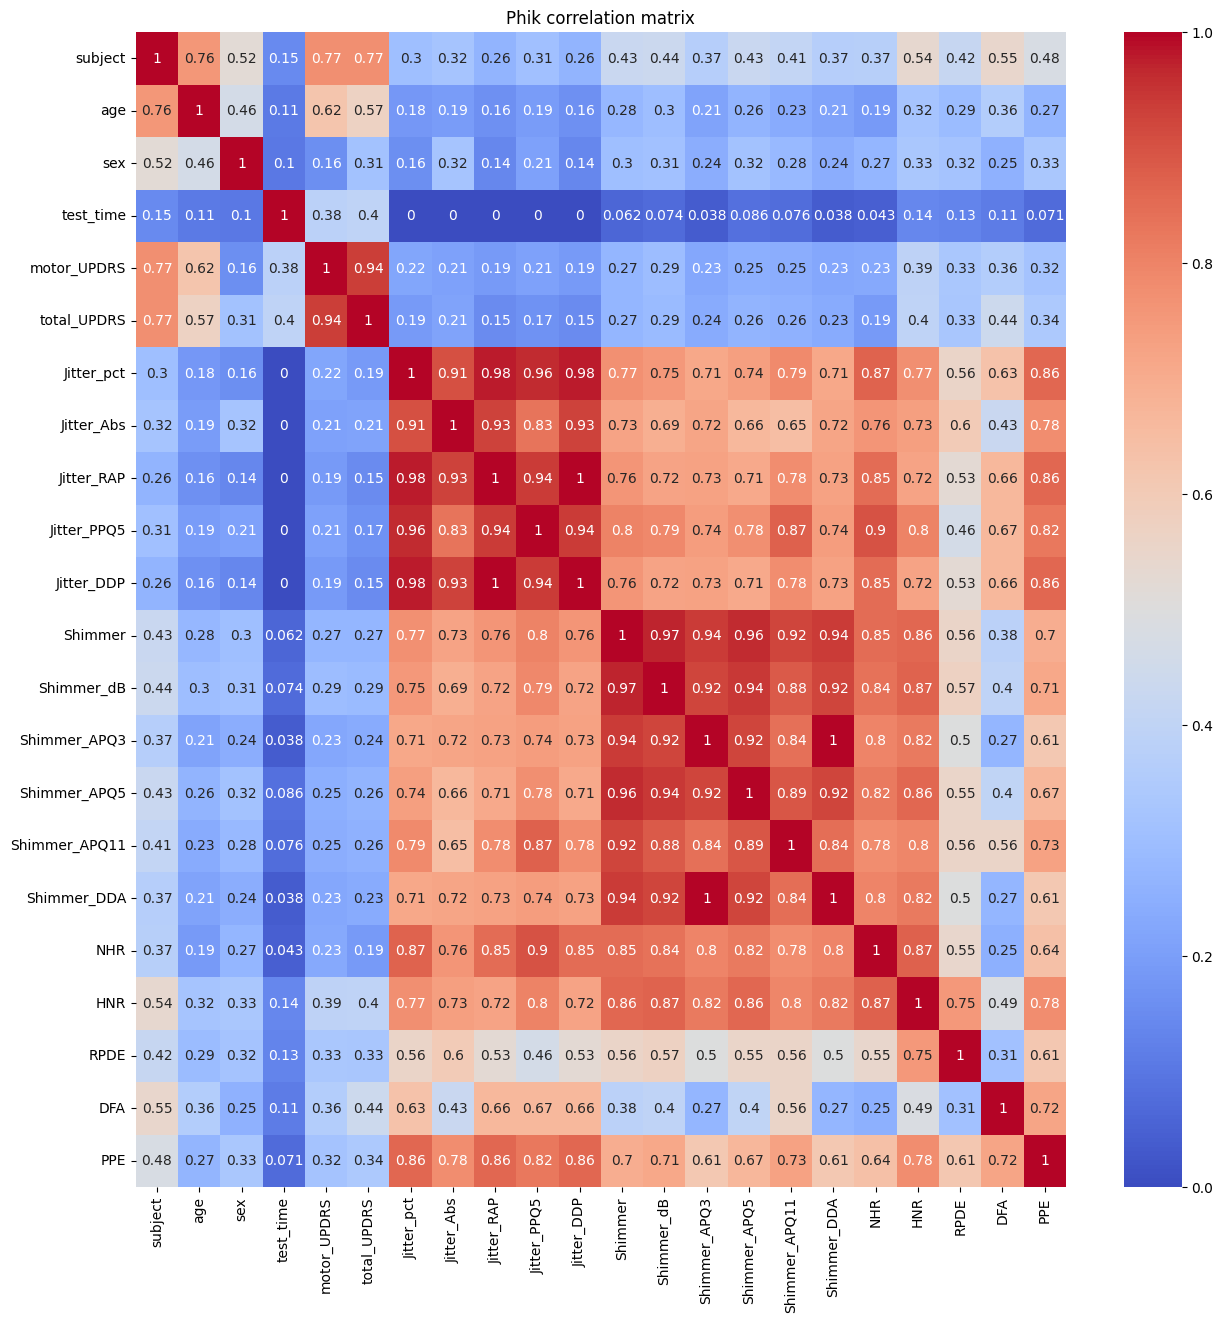

In [10]:
# Visualizing the correlation using phik_matrix
plt.figure(figsize=(15, 15))
# add title to the heatmap
title = 'Phik correlation matrix'
plt.title(title)
sns.heatmap(df.phik_matrix(), annot=True, cmap='coolwarm')

<p> Phik can analyze categorical data, since subject is categorical column, it shows up strong correlation with age and UPDRS.<br>
In Pearson Correlation, sex has small correlation, but in Phik matrix has higher correlation.</p>

In [11]:
# Since the dataset is based on 42 people, so let's check based on the subject number
df['subject'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42], dtype=int64)

In [12]:
# Subject has 42 unique values, but the total number of rows is 5875. This means that each subject has multiple rows.
# let's check the number of rows for each subject
df['subject'].value_counts()

subject
29    168
41    165
35    165
7     161
5     156
6     156
24    156
34    155
9     152
8     150
1     149
38    149
10    148
2     145
17    144
25    144
42    144
3     144
15    143
39    143
40    142
37    140
16    138
23    138
11    138
4     137
14    136
33    135
20    134
28    134
26    130
31    130
27    129
36    129
19    129
18    126
30    126
21    123
13    112
22    112
12    107
32    101
Name: count, dtype: int64

In [13]:
# I need to group the UPDRS column based on the subject numbers 
df_grouped = df.groupby('subject').describe()['motor_UPDRS']    
df_grouped

,count,mean,std,min,25%,50%,75%,max
subject,,,,,,,,
1,149.0,31.898933,2.667105,28.1990,29.68200,31.30900,34.11000,36.9780
2,145.0,13.812538,2.427066,11.0780,11.92500,12.83400,15.75600,18.8190
3,144.0,27.124785,1.736198,23.4370,25.85175,28.03400,28.48425,28.9240
4,137.0,15.790825,2.542993,10.7370,13.40000,17.01200,17.98300,18.7700
5,156.0,31.632603,0.906145,31.0000,31.00000,31.00000,32.24400,33.7610
6,156.0,27.531692,1.085359,26.0370,26.65200,27.34400,28.10400,29.9710
7,161.0,16.047062,1.297724,13.0420,15.23400,16.36500,17.04200,17.9450
8,150.0,19.887020,1.592021,18.0930,18.55000,19.02900,21.18100,23.0310
9,152.0,18.312362,1.595781,17.0000,17.00000,17.60700,19.51600,21.7440


In [14]:
# let's find which patients got biggest gap during the test
df_grouped['diff'] = df_grouped['max'] - df_grouped['min']
df_grouped.sort_values(by='diff', ascending=False)

,count,mean,std,min,25%,50%,75%,max,diff
subject,,,,,,,,,
17,144.0,26.432299,4.286278,19.0930,22.79550,26.44050,30.06800,33.8790,14.7860
37,140.0,31.860643,4.431930,22.9620,28.09200,33.48100,35.76100,37.6640,14.7020
21,123.0,29.092659,4.049089,25.0660,26.13800,27.21200,31.50500,39.5110,14.4450
31,130.0,26.404285,4.066760,18.2450,22.85600,27.86050,29.31700,31.9670,13.7220
30,126.0,25.915119,4.010505,19.4170,22.30800,25.81250,29.14400,32.5350,13.1180
14,136.0,13.014450,4.059433,6.5651,9.25960,13.56800,16.80100,19.4910,12.9259
13,112.0,19.516768,3.666274,16.0720,16.43300,17.79700,22.86900,27.1080,11.0360
32,101.0,9.944266,3.615827,6.0102,6.69240,7.92400,12.93600,16.4870,10.4768
25,144.0,28.732562,3.162420,24.2060,25.98225,28.48000,31.53625,33.9680,9.7620


**The biggest gap is 14 and the smallest gap is 0.9623. But some patients like subject 17, during 6 months got more score even, them min score is 19 but the max score is 36 which means the disease is improved faster.**<br>
**Same thing for subject 14 and 32.**
**Subject 5 could control the disease progress because the min is 31 and max is 33. So during 6 months, only 2 scores went up.**

In [15]:
# What I found from dataset description, this dataset is recorded for 42 people during 6 months.
# Test time is the number of days since recruitment. It is a continuous variable.
# let's calculate the number of days for each subject
df[df['subject'] == 1]['test_time'].sum()

13285.800000000003

In [16]:
df[df['subject'] == 1]['test_time'].max()


174.7

In [17]:
df['test_time'].max()

215.5

In [18]:
# loading the HTML file 
#HTML(filename='dataset_regression/parkinsons_report.html')     

In [19]:
# using the variance inflation factor (VIF) to check for multicollinearity in the dataset
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
vif_data

,feature,VIF
0,subject,5.407584e+00
1,age,5.906859e+01
2,sex,2.236482e+00
3,test_time,4.122336e+00
4,motor_UPDRS,8.356856e+01
5,total_UPDRS,9.286866e+01
6,Jitter_pct,1.953758e+02
7,Jitter_Abs,1.976839e+01
8,Jitter_RAP,2.539618e+06
9,Jitter_PPQ5,5.500925e+01


In [ ]:
# let's drop the total UPDRS column because it has a high VIF value and related to the motor UPDRS.
df = df.drop(columns=['total_UPDRS'], axis=1)   

In [21]:
# Now I am going to split the data into features and target
X = df.drop(columns=['motor_UPDRS'], axis=1)
y = df['motor_UPDRS'] 

In [22]:
ransac = RANSACRegressor(residual_threshold=25)
ransac.fit(X, y)

RANSACRegressor(residual_threshold=25)

In [23]:
inlier_mask = ransac.inlier_mask_
outliers = df[~inlier_mask]
inliers = df[inlier_mask]

print(f"Inliers: {len(inliers)}")
print(f"Outliers: {len(outliers)}")
df = inliers

Inliers: 5303
Outliers: 560


In [24]:
df.shape    

(5303, 21)

<div style="text-align:center;font-size:30px; ont-weight:bold;">Benchmark for Selection Features for Regression Data. </div>

<p> I am planning to try all selection Features methods for Regression Dataset.<br>
I have here:<br>
1-SelectBest<br>
2-RFE <br>
3-Lasso Regression <br>
4-RandomForestRegression<br>
5-PCA</p>

In [25]:
methods = {
    'SelectKBest': SelectKBest(score_func=f_regression, k='all'),
    'RFE': RFE(estimator=LinearRegression(), n_features_to_select=1),
    'Lasso': SelectFromModel(Lasso()),
    'RandomForest':RandomForestRegressor(n_estimators=100, random_state=42),   
    #PCA':PCA(n_components=10)
}

In [26]:
results = []

for name, method in methods.items():
    match name:
        case 'SelectKBest':
            method.fit(X, y)
            selected_features = pd.DataFrame({
                'Feature': X.columns, 
                'Score': method.scores_}).sort_values(by='Score', ascending=False)
            
        case 'RFE':
            method.fit(X, y)
            selected_features = pd.DataFrame({
                'Feature': X.columns, 
                'Ranking': method.ranking_}).sort_values(by='Ranking', ascending=True)
            
        case 'Lasso':
            lasso = Lasso(alpha=0.0005)
            lasso.fit(X, y)
            model = SelectFromModel(lasso, prefit=True)
            selected_features = pd.DataFrame({
                'Feature': X.columns, 
                'Selected': model.get_support()})
            selected_features = selected_features[selected_features['Selected']].sort_values(by='Feature', ascending=True)
            
        case 'RandomForest':
            method.fit(X, y)
            selected_features = pd.DataFrame({
                'Feature': X.columns, 
                'Importance': method.feature_importances_}).sort_values(by='Importance', ascending=False)
            
        #case 'PCA':
        #    method.fit(X)
        #    selected_features = pd.DataFrame({
        #       'Component': range(1, method.n_components_ + 1),
        #       'Explained Variance': method.explained_variance_ratio_
        #  })
            
    print(f'Method: {name}')
    print(selected_features)
    print('-' * 50)
    
    results.append(selected_features)   


Method: SelectKBest
          Feature       Score
1             age  477.501171
0         subject  400.290602
19            PPE  160.646244
16            HNR  148.784362
13  Shimmer_APQ11  111.940409
17           RPDE   98.315270
18            DFA   80.402508
10     Shimmer_dB   72.554911
9         Shimmer   62.667370
12   Shimmer_APQ5   50.591658
4      Jitter_pct   42.988686
14    Shimmer_DDA   42.358248
11   Shimmer_APQ3   42.358214
7     Jitter_PPQ5   34.668854
15            NHR   33.398191
8      Jitter_DDP   31.510875
6      Jitter_RAP   31.498570
3       test_time   28.535259
5      Jitter_Abs   15.492393
2             sex    5.523178
--------------------------------------------------
Method: RFE
          Feature  Ranking
6      Jitter_RAP        1
8      Jitter_DDP        2
5      Jitter_Abs        3
11   Shimmer_APQ3        4
14    Shimmer_DDA        5
4      Jitter_pct        6
7     Jitter_PPQ5        7
12   Shimmer_APQ5        8
13  Shimmer_APQ11        9
9         Shimmer

In [27]:
# For training model the dont need to have the subject column and test_time column.
# So let's drop these columns
df = df.drop(columns=['subject', 'test_time'], axis=1)

In [28]:
# Save the dataset as a CSV file
df.to_csv('dataset_regression/parkinsons_updrs_cleaned.data', index=False)